## Parallelising the Discrete SEIR Model

This notebook effectively takes what the discrete SEIR notebook does and adds a parallel loop to it so can run multiple simulations quicker.

In [113]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv

In [2]:
# Reads in a text file into an array
def readFile(fileName):
        fileObj = open(fileName, "r") #opens the file in read mode
        words = fileObj.read().splitlines() #puts the file into an array
        arr = []
        for item in words:
            arr.append(item.split('\t'))
        fileObj.close()
        return arr

In [3]:
# WALOC has town, population, long, latt
waloc = readFile('/Volumes/HardDrive/WALOC.txt')

In [4]:
# This bit just helps with the plotting function later
my_data = genfromtxt('/Volumes/HardDrive/WA_297_big/WA_297_20200322_20200328.txt', delimiter='\t')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Generate labels for later (plotting) and for checking what town I'm dealing with
towns = [item[0] for item in waloc]
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [5]:
popn = [int(item[1].replace(',' , '')) for item in waloc][:58] #defined globally
print(popn)

[1874578, 71090, 31982, 29875, 29373, 25329, 15828, 13984, 13828, 10421, 8859, 7192, 6548, 6392, 6039, 4567, 4426, 4341, 4274, 4213, 3896, 3702, 3325, 2956, 2782, 2750, 2636, 2558, 2548, 2520, 2486, 2397, 2269, 2052, 2020, 1905, 1887, 1789, 1703, 1577, 1572, 1546, 1546, 1484, 1448, 1425, 1359, 1358, 1349, 1265, 1227, 1165, 1147, 1141, 1109, 1104, 80813, 780]


In [49]:
# Read in the adjacency matrices into a dictionary. Choose if wanting kalman filtered, or (kalman filtered and) stochasticised
wa_297 = os.listdir("/Volumes/HardDrive/kalman_all2all_big/")[:-1]
d = {}
for i in range(len(wa_297)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/kalman_all2all_big/"+wa_297[i], header = None, sep ='\t')*1*10**8

In [50]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(wa_297)):
    df += d[str(i)]
df = df/len(wa_297)
d['100'] = df

In [51]:
# Define the SEIR model equations (note the division by population as the key difference from the continuous case, 
# as well as doing the incoming/outgoing populations later)
def seir(params,x,popn):
    xdot = list(np.zeros(4*num))
    for i in range(num):
        xdot[4*i+0] = -params[5*i]*x[4*i]*x[4*i+2]/popn[i] - params[5*i+4]*x[4*i]   
        xdot[4*i+1] = params[5*i]*x[4*i]*x[4*i+2]/popn[i]  - params[5*i+1]*x[4*i+1]  + params[5*i+3]*x[4*i+3]*x[4*i+2]/popn[i]
        xdot[4*i+2] = params[5*i+1]*x[4*i+1] - params[5*i+2]*x[4*i+2]
        xdot[4*i+3] = params[5*i+2]*x[4*i+2] + params[5*i+4]*x[4*i] - params[5*i+3]*x[4*i+3]*x[4*i+2]/popn[i]
    return xdot
    

In [52]:
# No longer maybe, this is *definitely* the binomial function. Takes in a discrete flow of population, 
# and based on the probability (p) of an individual being in the specified compartment in the initial (outgoing) town.
def maybe_binomialise(flow,p):
    if flow == 0:
        return 0
    else:
        dist = [binom.cdf(ppl, flow, p) for ppl in range(flow)]
        r1 = random.rand()
        for j in range(len(dist)):
            if r1 < dist[j]:
                move = j
                break
            else:
                move = flow
        return move

In [53]:
def bernoulli(flow,p1,p2,p3,p4):
    if flow == 0:
        return [0,0,0,0]
    else:
        vector = []
        for i in range(flow):
            r1 = random.rand()
            if r1 < p1:
                vector.append(0)
            elif (r1>p1) & (r1 < (p1+p2)):
                vector.append(1)
            elif (r1 > p1+p2) & (r1 < p1+p2+p3):
                vector.append(2)
            else:
                vector.append(3)
        occ = dict(collections.Counter(vector))
        for i in range(4):
            occ[i] = occ.get(i,0)
        return occ

In [94]:
# The big one
def dynamics(x_init,days,crit,params,breaks,steps):
    x = x_init #Initial values for all towns!
    
    # Iterate over each day
    for day in range(days):
        print(day)
        
        # Step 1: if a town's number of infections has passed the critical value, immediately 'impose restrictions'
        # and decrease alpha and omega so that R0 is roughly 1
        for i in range(num):
            if x[-1][4*i+2] > crit:
                params[5*i] = 0.16
                params[5*i +3 ] = 0.1*0.16
                
            if (x[-1][4*i+2] > 0) & (breaks[i][1] == 0):
                # Breaks has list of tuples - in each tuple, if the second entry is 1 the pandemic has reached the 
                # town, with the first entry being how long (days) it took to get there.
                breaks[i] = (day,1)
         
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
        
        # Step 3: If the 7th day of the week, get the flow and feed it into the binomial function, 
        # which will return how many people in that particular compartment moved from one town to the other.
        if day%7 == 0:
            week = int(day//7)
            if week < 67:
                flow = d[str(week)].copy()
            else:
                flow = d['100'].copy() #Average flow
            
            for i in range(num):
                for j in range(num):
                    #for k in range(4):
                        # Get discrete number moving from town i to town j in compartment k.
                    #    binn = maybe_binomialise(int(flow[i][j]),x[-1][4*i+k]/popn[i])
                    #    x[-1][4*j+k] += binn
                    #    x[-1][4*i+k] -= binn
                    pop = popn[i]
                    move = bernoulli(int(flow[i][j]),x[-1][4*i]/pop,x[-1][4*i+1]/pop,x[-1][4*i+2]/pop,x[-1][4*i+3]/pop)
                    for k in range(4):
                        x[-1][4*j+k] += move[k]
                        x[-1][4*i+k] -= move[k]
                        
    return x,breaks

In [101]:
def plotting(y):
    s = list(zip(*y))

    for i in range(num):
        plt.figure(figsize = (6,6))
        plt.plot(s[4*i],'k', label ='Susceptible')
        plt.plot(s[4*i+1],'b', label = 'Exposed')
        plt.plot(s[4*i+2],'r', label = 'Infected')
        plt.plot(s[4*i+3],'y', label = 'Recovered/Vaccinated')
        plt.title(labeldict[i])
        plt.legend()
        plt.xlabel("Days")
        plt.ylabel("Number of infected")
        plt.xlim([0,steps*days])
        plt.ylim([0,10000])
        plt.tight_layout()

In [103]:
num = 58 #define globally

# Set the initial town values (when doing final simulations make sure this is accurate)
x_init = [1000000,0,10,popn[0]-1000000-10]
y_init = []
for i in range(1,num):
    y_init.append(int(popn[i]/2))
    y_init.append(0)
    y_init.append(0)
    y_init.append(int(popn[i]/2))
town_init = [x_init+y_init]

# Set number of days for this simulation
days = 700

# Set critical value at which to set R0 ~ 1
crit = 200

# [alpha, beta, gamma, omega, mu]
params = [0.75, 1/5.2, 1/12,0.075,0.0001]*num

#Initialise the outbreaks info
breaks = [(0,0)]*num

steps = 1

In [104]:
# Call the function (just once)
y, breaks = dynamics(town_init,days, crit, params, breaks,steps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
# Without parallelisation
res = []
start = time.time()
for i in range(3):
    # For some strange reason, all these variables have to be defined here to get different results otherwise 
    # it's the exact same simulation over and over
    num = 58 #define globally
    x_init = [1000000,0,10,popn[0]-1000000-10]
    y_init = []
    for i in range(1,num):
        y_init.append(int(popn[i]/2))
        y_init.append(0)
        y_init.append(0)
        y_init.append(int(popn[i]/2))
    town_init = [x_init+y_init]
    days = 700
    crit = 200
    params = [0.75, 1/5.2, 1/12,0.075,0.0001]*num
    breaks = [(0,0)]*num
    steps = 1
    res.append(dynamics(town_init,days, crit, params, breaks,steps))
end = time.time()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
print(start-end)

-33.429800271987915


In [107]:
# With Parallelisation
start = time.time()
# For some strange reason, all these variables have to be defined here to get different results otherwise 
# it's the exact same simulation over and over
num = 58 #define globally
x_init = [1000000,0,10,popn[0]-1000000-10] 
y_init = []
for i in range(1,num):
    y_init.append(int(popn[i]/2))
    y_init.append(0)
    y_init.append(0)
    y_init.append(int(popn[i]/2))
town_init = [x_init+y_init]
days = 700
crit = 200
# [alpha, beta, gamma, omega, mu]
params = [0.75, 1/5.2, 1/12,0.075,0.0001]*num
breaks = [(0,0)]*num
steps = 1

# The parallelisation:
# Choose n_jobs = -1 if want all processors, otherwise decide how many. range(x) is how many simulations you wanna do
results = Parallel(n_jobs=-1)(delayed(dynamics)(town_init,days, crit, params, breaks,steps) for _ in range(3))

end = time.time()

print(end - start)

12.649826049804688


In [110]:
print(results[0][1])

[(0, 1), (295, 1), (0, 0), (169, 1), (484, 1), (253, 1), (226, 1), (177, 1), (0, 0), (0, 0), (51, 1), (330, 1), (330, 1), (316, 1), (281, 1), (268, 1), (0, 0), (0, 0), (0, 0), (393, 1), (176, 1), (0, 0), (0, 0), (281, 1), (0, 0), (338, 1), (0, 0), (470, 1), (372, 1), (344, 1), (0, 0), (0, 0), (120, 1), (0, 0), (296, 1), (513, 1), (23, 1), (253, 1), (520, 1), (0, 0), (260, 1), (295, 1), (0, 0), (28, 1), (393, 1), (0, 0), (246, 1), (0, 0), (0, 0), (155, 1), (338, 1), (0, 0), (0, 0), (0, 0), (330, 1), (218, 1), (114, 1), (0, 0)]


In [116]:
for i in range(len(results)):
    temp_y = pd.DataFrame(results[i][0])
    temp_b = pd.DataFrame(results[i][1])
    temp_y.to_csv("/Volumes/HardDrive/results/y_"+str(i)+".csv",sep = ',',index = False, header = False)
    temp_b.to_csv("/Volumes/HardDrive/results/breaks_"+str(i)+".csv",sep = ',',index = False, header = False)

In [60]:
averages = [0]*58
nonzeros = [0]*58
for item in results:
    for i in range(len(averages)):
        if item[1][i][0] != 0:
            averages[i] += item[1][i][0]
            nonzeros[i] += 1

for i in range(len(averages)):
    if nonzeros[i] != 0:
        averages[i] = averages[i]/nonzeros[i]

In [61]:
for i in range(num):
    if averages[i] > 0:
        print(labeldict[i],averages[i])
        
print('------Not Affected:------')
for i in range(num):
    if averages[i] == 0:
        print(labeldict[i])

Bunbury 625.0
Kalgoorlie-Boulder 381.6666666666667
Busselton 534.0
Karratha 467.6666666666667
Broome 505.6666666666667
Yanchep 95.0
Northam 561.5
Dunsborough 667.0
Newman 330.3333333333333
Pinjarra 240.0
Tom Price 264.6666666666667
York 673.0
Donnybrook 695.0
Two Rocks 270.5
Capel 611.0
Bullsbrook 58.0
Kambalda West 500.3333333333333
Wickham 547.6666666666666
Cowaramup 680.0
Mundijong 61.333333333333336
Paraburdoo 249.0
Serpentine 258.3333333333333
Dampier 479.6666666666667
Mandurah 291.3333333333333
------Not Affected:------
Perth
Geraldton
Albany
Port Hedland
Esperance
Collie
Margaret River
Carnarvon
Kununurra
Narrogin
Manjimup
Katanning
Derby
Port Denison-Dongara
Harvey
Merredin
Denmark
Exmouth
Waroona
Drummond Cove
Mount Barker
Little Grove
Moora
Halls Creek
Bridgetown
Jurien Bay
Wagin
Kalbarri
Binningup
Kojonup
Boddington-Ranford
Fitzroy Crossing
Augusta
Wyndham


In [105]:
for i in range(num):
    if breaks[i][1] > 0:
        print(labeldict[i],breaks[i][0])
        
print('------Not Affected:------')
for i in range(num):
    if breaks[i][0] == 0:
        print(labeldict[i])

Perth 0
Bunbury 303
Kalgoorlie-Boulder 407
Albany 527
Busselton 309
Karratha 163
Broome 393
Yanchep 23
Collie 345
Northam 127
Margaret River 372
Dunsborough 351
Newman 162
Manjimup 393
Pinjarra 212
Tom Price 345
Harvey 407
Denmark 484
York 149
Donnybrook 352
Two Rocks 134
Capel 330
Mount Barker 520
Bullsbrook 22
Kambalda West 456
Little Grove 554
Wickham 197
Cowaramup 345
Mundijong 63
Bridgetown 407
Paraburdoo 317
Serpentine 169
Binningup 359
Augusta 380
Dampier 156
Mandurah 149
------Not Affected:------
Perth
Geraldton
Port Hedland
Esperance
Carnarvon
Kununurra
Narrogin
Katanning
Derby
Port Denison-Dongara
Merredin
Exmouth
Waroona
Drummond Cove
Moora
Halls Creek
Jurien Bay
Wagin
Kalbarri
Kojonup
Boddington-Ranford
Fitzroy Crossing
Wyndham


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


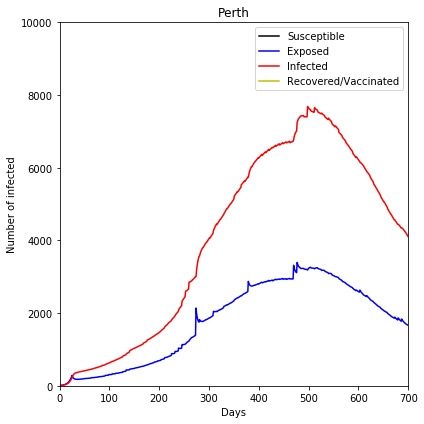

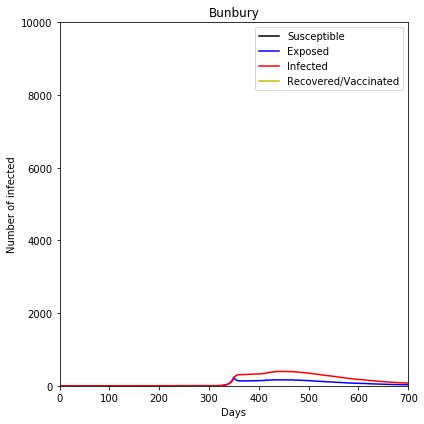

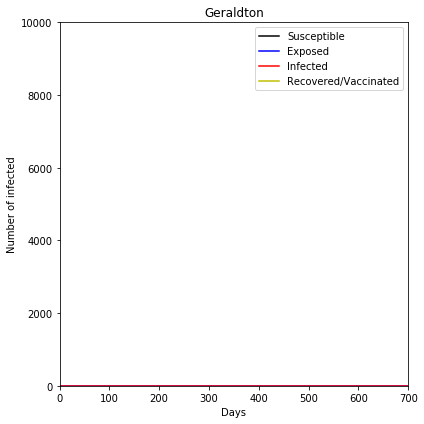

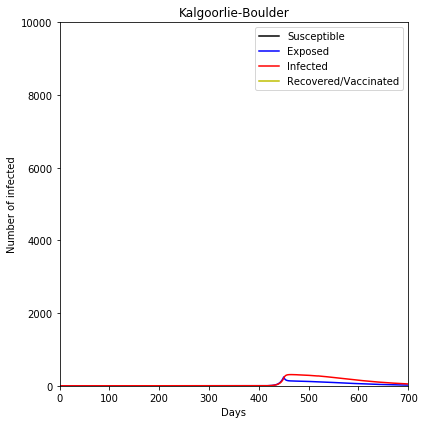

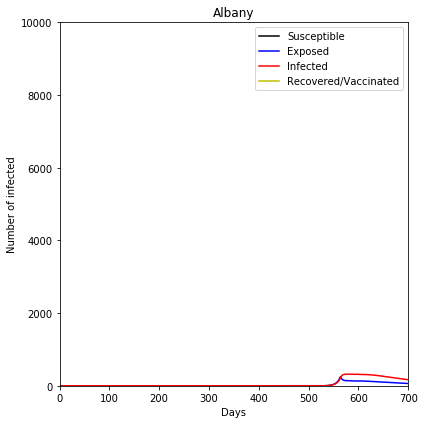

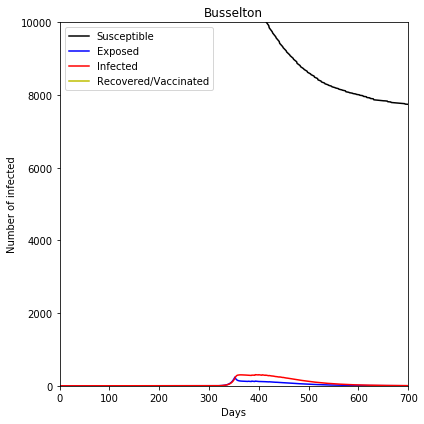

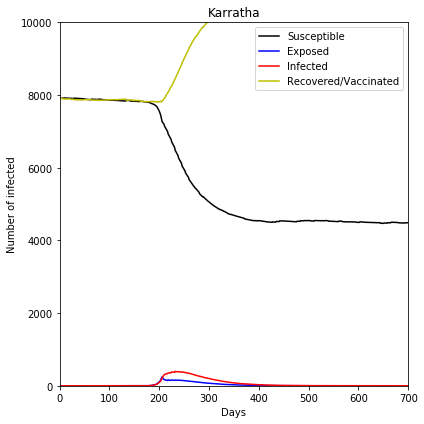

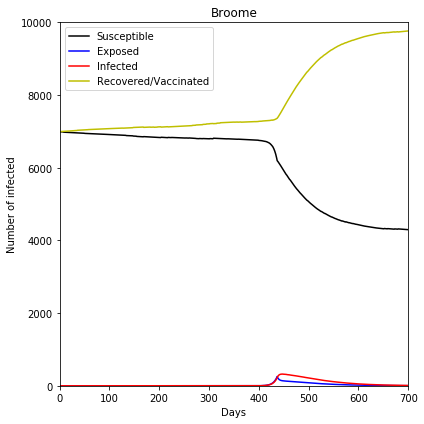

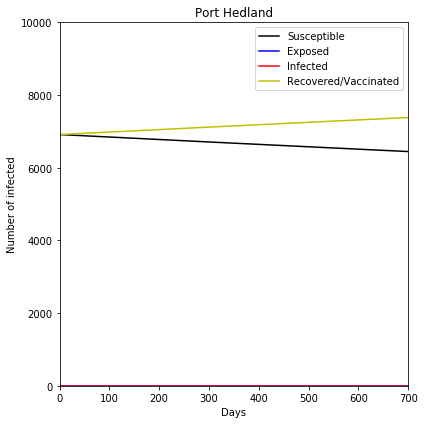

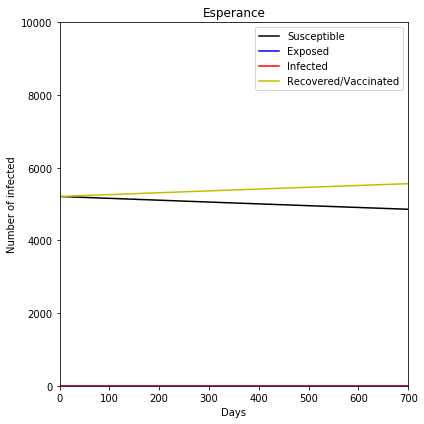

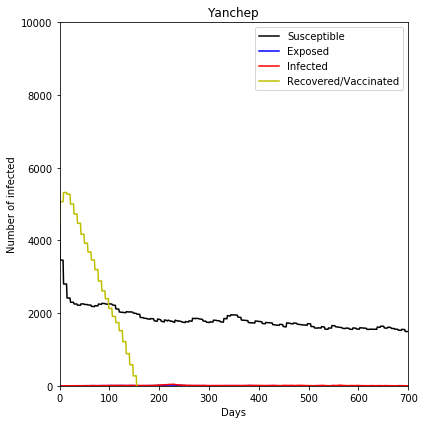

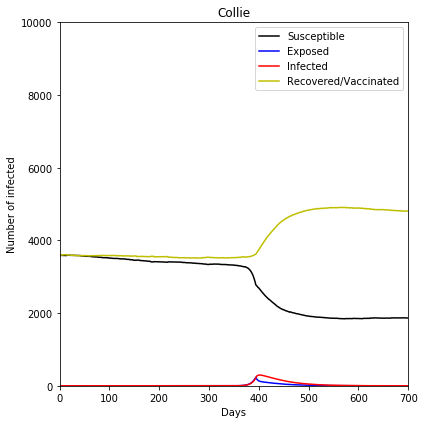

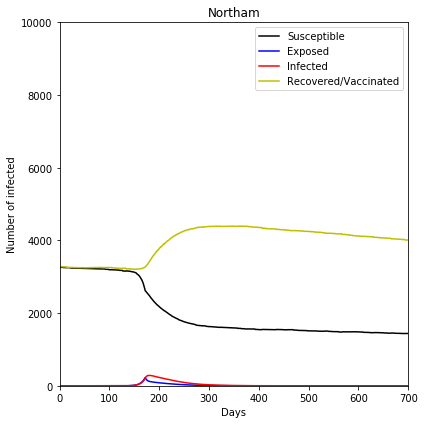

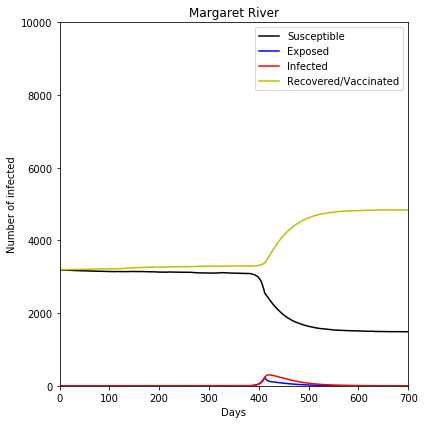

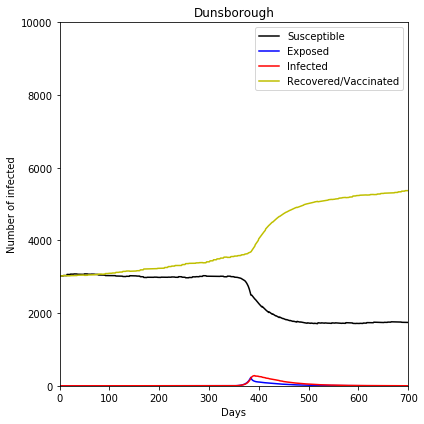

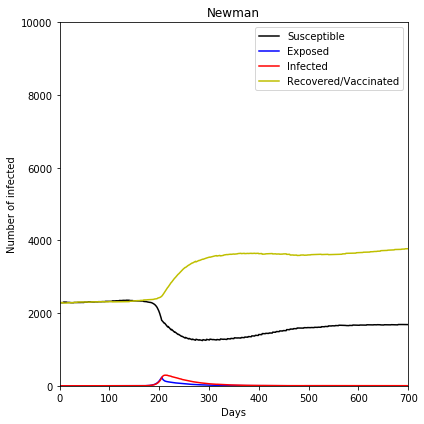

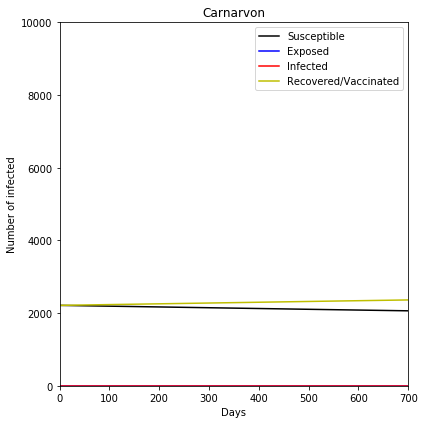

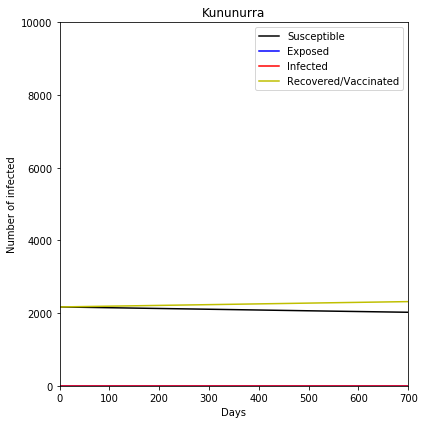

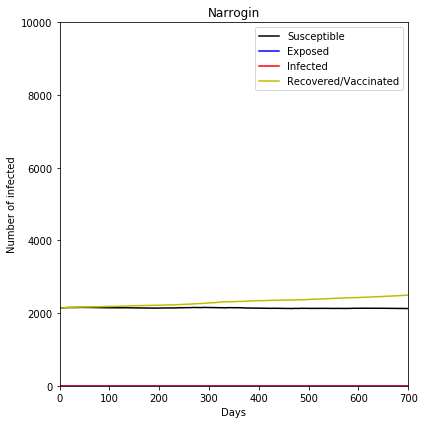

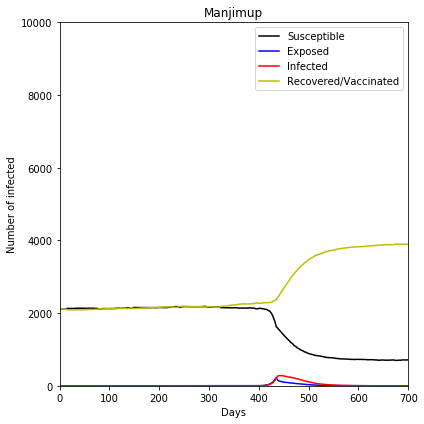

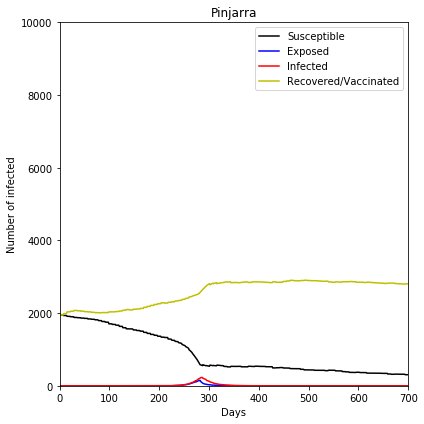

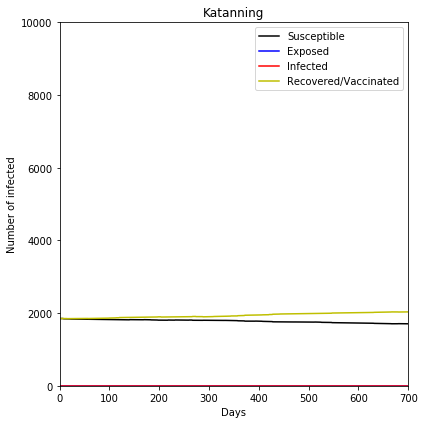

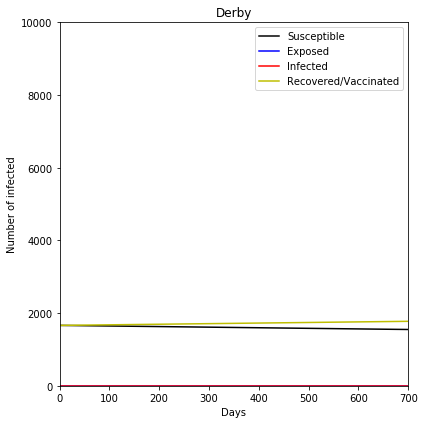

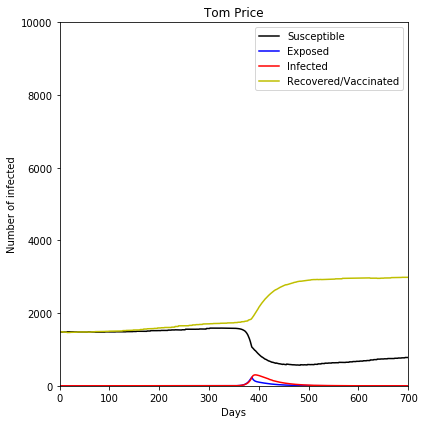

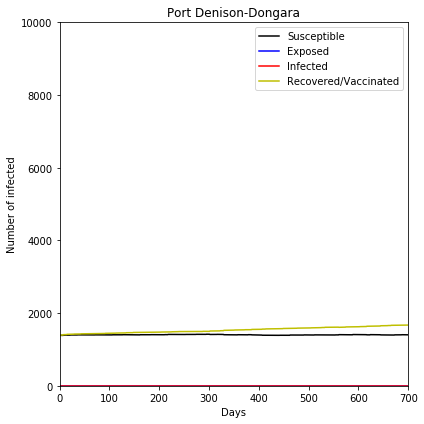

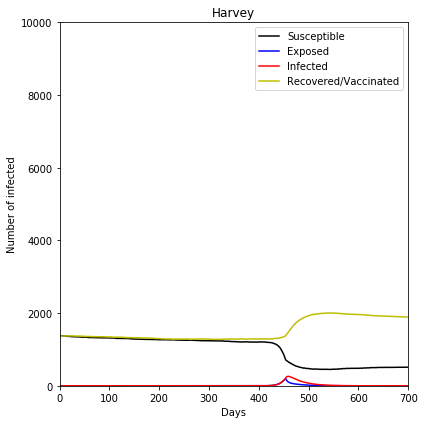

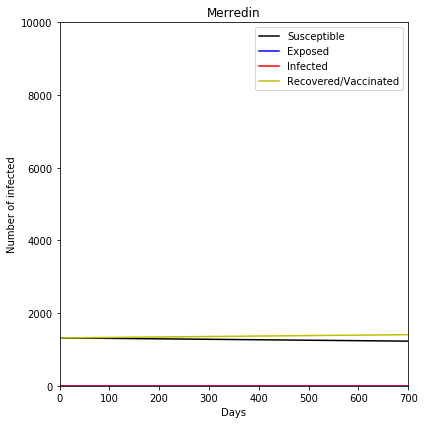

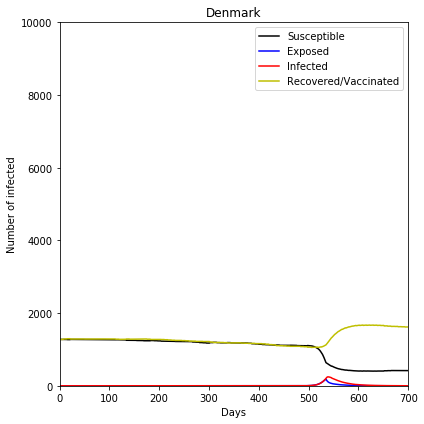

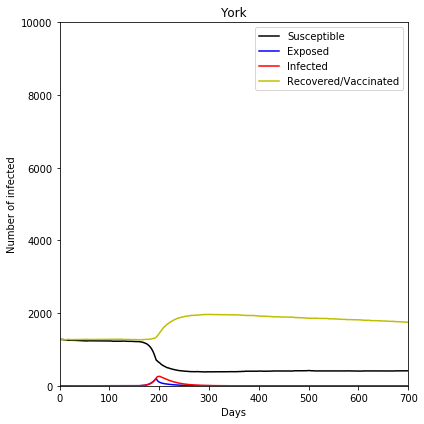

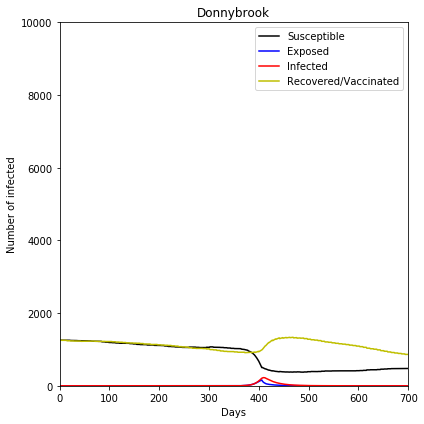

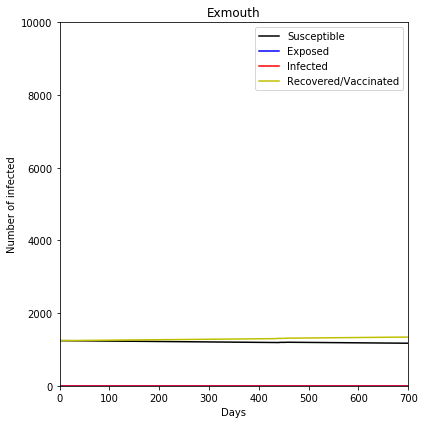

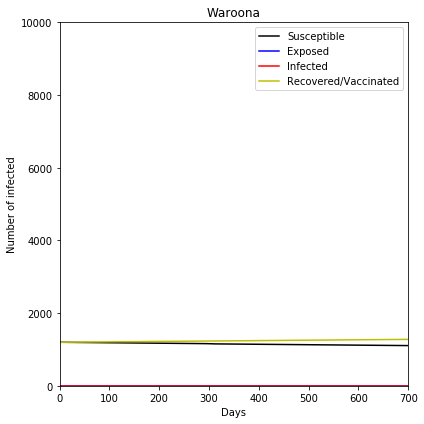

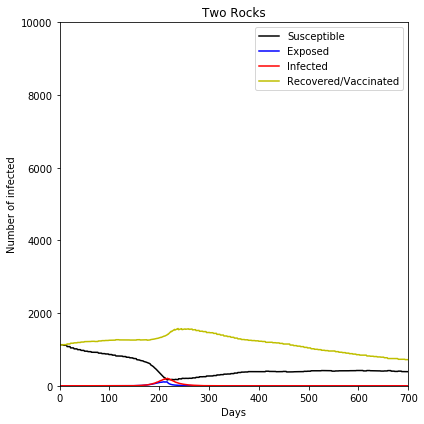

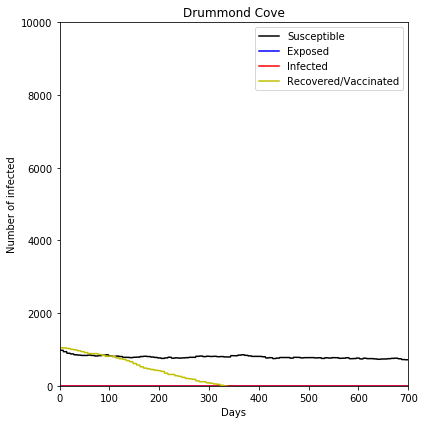

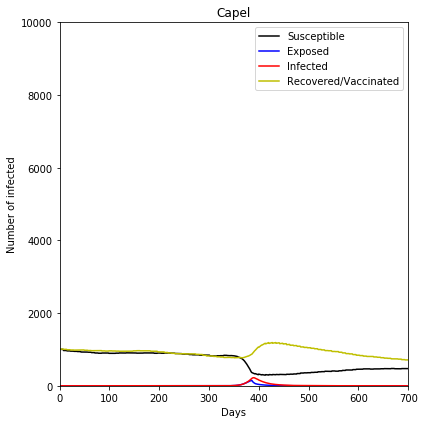

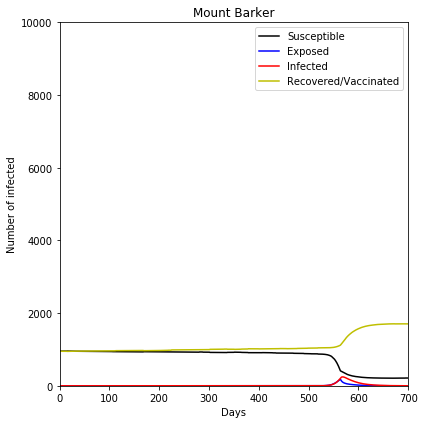

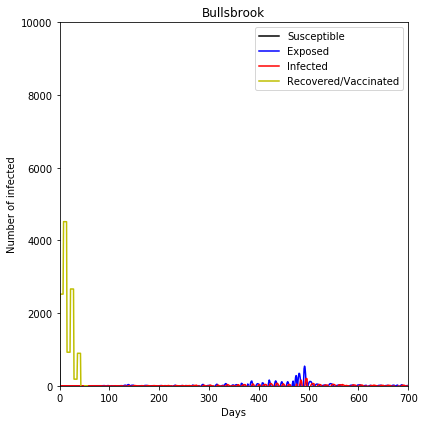

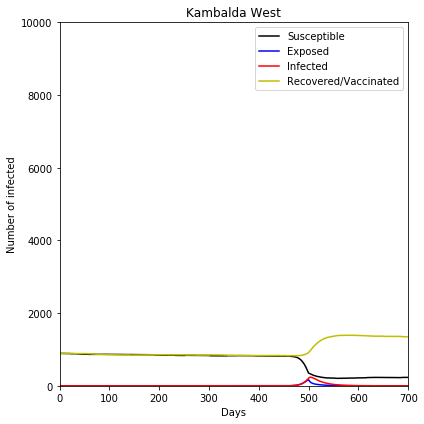

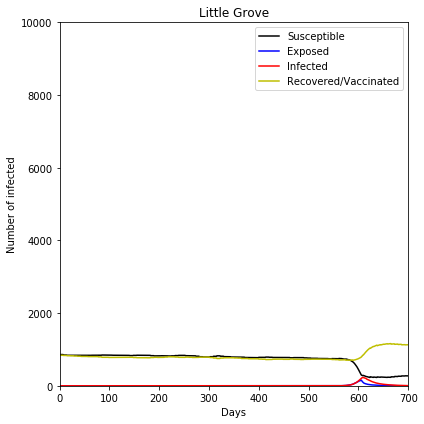

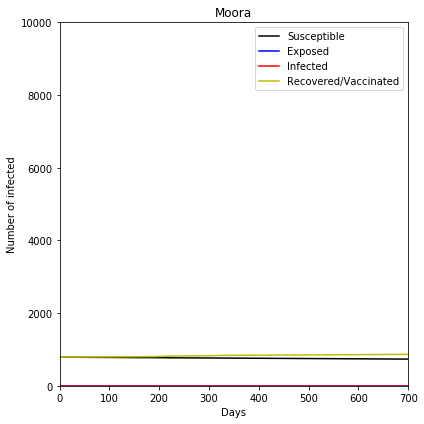

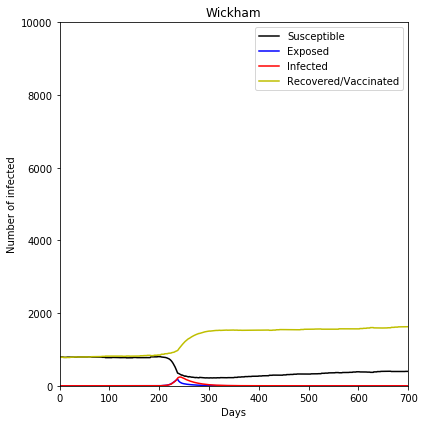

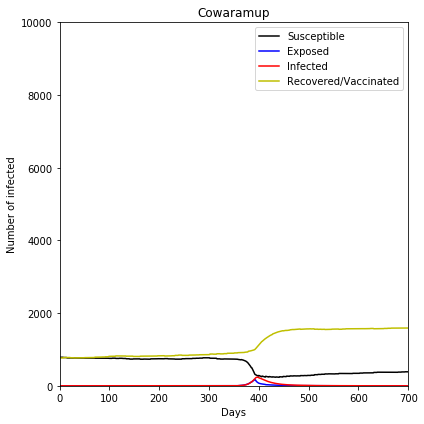

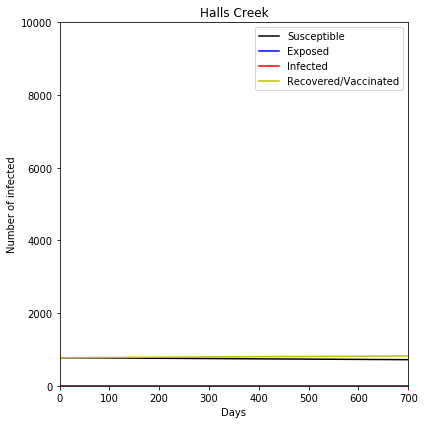

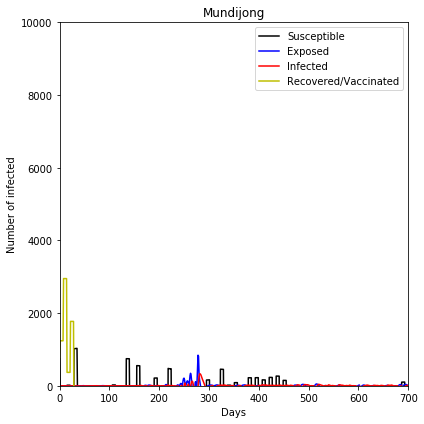

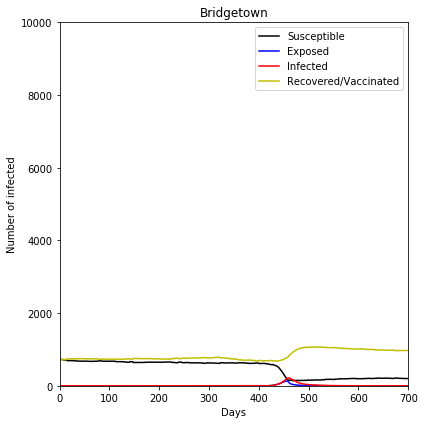

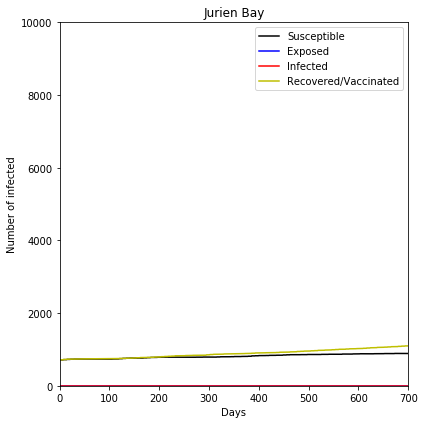

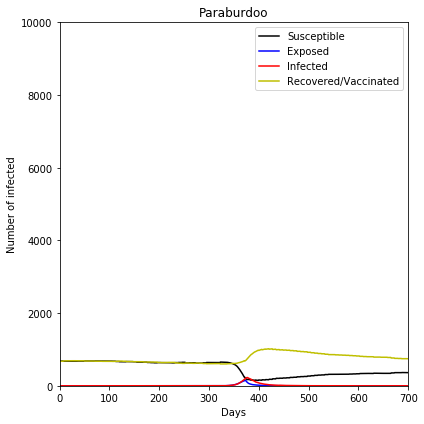

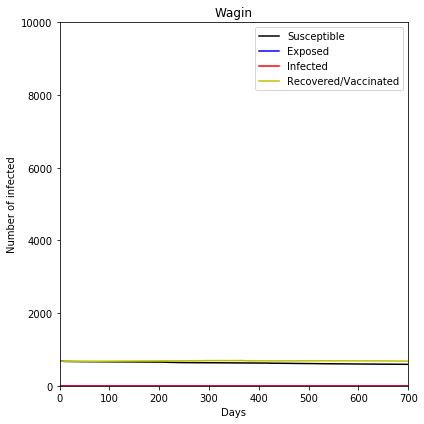

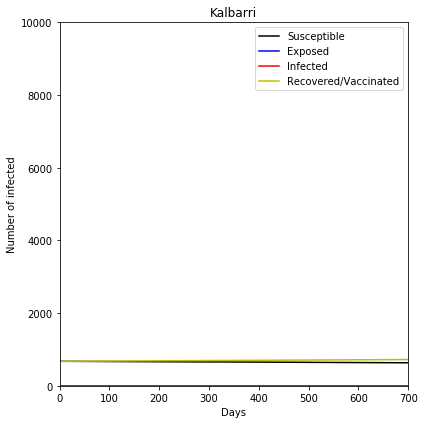

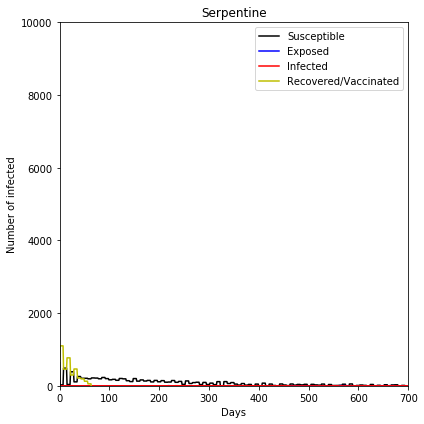

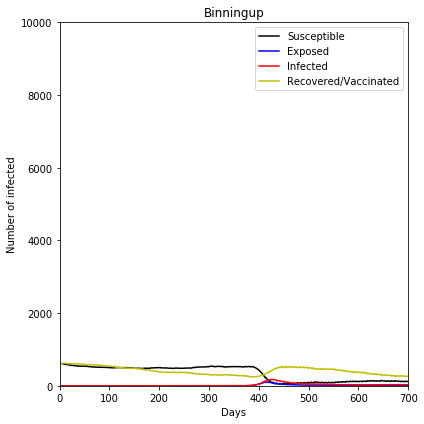

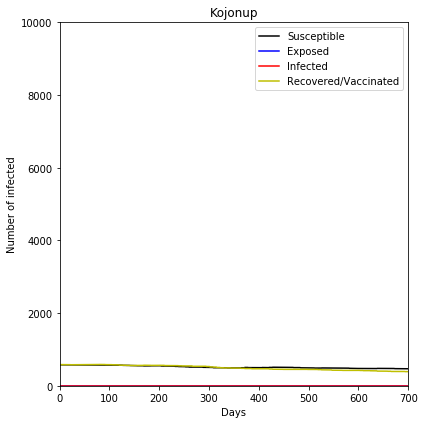

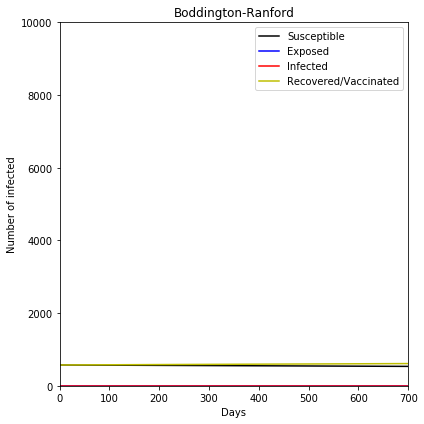

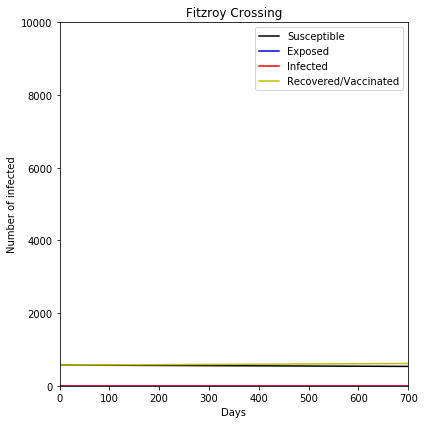

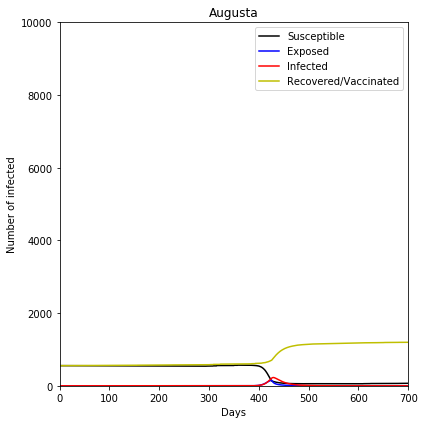

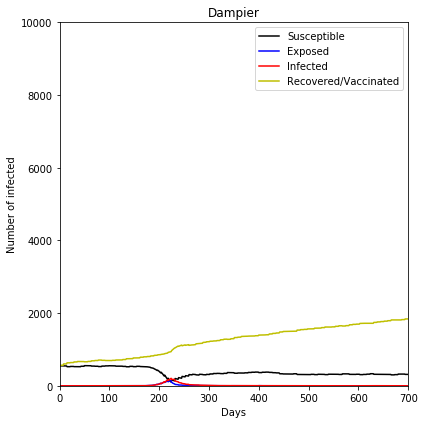

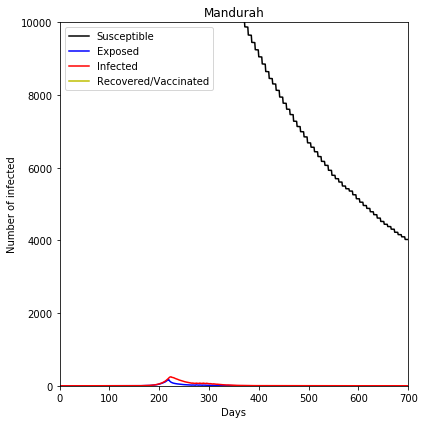

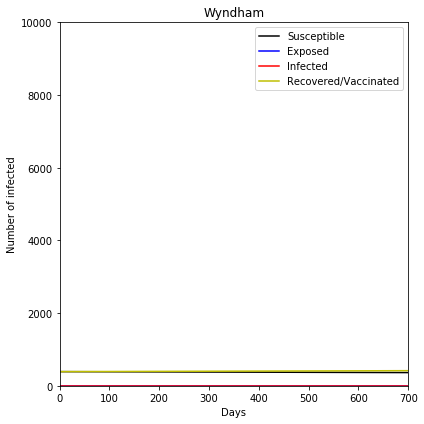

In [106]:
plotting(y)

In [134]:
def not_binomialise(inc,out,x,popn):
    binn = []
    for i in range(4):
        dist_in = [binom.cdf(ppl, inc, x[i]/popn) for ppl in range(inc)]
        dist_out = [binom.cdf(ppl, out, p_out) for ppl in range(out)]
        r1 = random.rand()
        r2 = random.rand()
        for j in range(len(dist_in)):
            if r1 < dist_in[j]:
                move_in = j
                break
            else:
                move_in = inc
        for j in range(len(dist_out)):
            if r2 < dist_out[j]:
                move_out = j
                break
            else:
                move_out = out
        binn.append(move_in - move_out)
    return binn

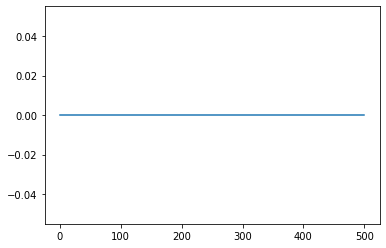

In [102]:
plt.plot(list(zip(*y))[10])

In [35]:
binomialise(600,500,0.1,0.1)

[12, 18, 12, 10]

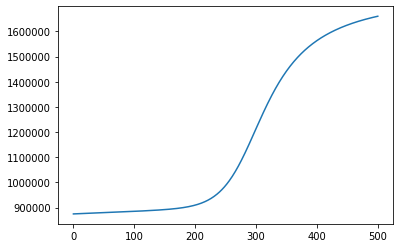

In [18]:
x = [[1000000,0,10,popn[0]-1000000-10]]
for t in range(500):
    xdot = seir([0.2, 1/5.2, 1/12,0.09,0.0001],x[-1],popn)
    x.append([sum(i) for i in zip(*[x[t],xdot])])
plt.plot(list(zip(*x))[3])